# 02 - Cell Type Annotation

This notebook demonstrates clustering and cell type annotation for single-cell data.

## Overview

Steps include:
1. Load preprocessed data
2. Neighbor graph construction
3. Clustering (Leiden algorithm)
4. UMAP visualization
5. Marker gene identification
6. Cell type annotation

## Setup

In [2]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

##################################################
suffix = 'combined.26.01.26' # change to date of analysis #
##################################################

# Set working directory to notebook location
notebook_dir = r'z:\thornes\Pavlicev_lab_rotation\FLUXestimator\notebooks'
os.chdir(notebook_dir)
print(f"Working directory: {os.getcwd()}")

# Configure scanpy
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white', figsize=(10, 10))

print(f"Scanpy version: {sc.__version__}")

sc_output_dir = rf'z:\thornes\Pavlicev_lab_rotation\FLUXestimator\results\single_cell_annotations\{suffix}'
if not os.path.exists(sc_output_dir):
    os.makedirs(sc_output_dir)


Working directory: z:\thornes\Pavlicev_lab_rotation\FLUXestimator\notebooks
Scanpy version: 1.11.5


C:\Users\dell\AppData\Local\Temp\ipykernel_12168\3403448708.py:22: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print(f"Scanpy version: {sc.__version__}")


## Load Configuration and Data

In [3]:
# Load configuration
with open('../config/analysis_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [5]:
# Load preprocessed data
adata = sc.read_h5ad(f'../data/processed/{suffix}/preprocessed_data.h5ad')

print(f"Loaded data: {adata.shape[0]} cells x {adata.shape[1]} genes")
adata

# Get normalized log-transformed expression as DataFrame
expr_df = pd.DataFrame(
    adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X,
    index=adata.obs_names,  # Cell barcodes as rows
    columns=adata.var_names  # Gene names as columns
)

# Display first few rows and columns
print(f"Expression matrix shape: {expr_df.shape}")
print(f"Cells: {expr_df.shape[0]}, Genes: {expr_df.shape[1]}")

#trasnpose matrix to have gees as rows and cells as columns
expr_df_transposed = expr_df.T

# Save to CSV
expr_df_transposed.to_csv(f'../data/processed/{suffix}/expression_matrix.csv')
print(f"Expression matrix saved to '../data/processed/{suffix}/expression_matrix.csv'")
expr_df_transposed.iloc[:5, :5]  # Display first 5 genes and 5 cells


Loaded data: 2815 cells x 21647 genes
Expression matrix shape: (2815, 21647)
Cells: 2815, Genes: 21647
Expression matrix saved to '../data/processed/combined.26.01.26/expression_matrix.csv'


AAACCCACAGCTGAAG-1  AAACCCAGTGATGGCA-1  AAACCCATCCATTCGC-1  \
Xkr4              -0.428044            0.910242           -0.428044   
Gm1992            -0.079078           -0.079078           -0.079078   
Gm19938           -0.158189           -0.158189           -0.158189   
Rp1               -0.041604           -0.041604           -0.041604   
Sox17             -0.138557           -0.138557           -0.138557   

         AAACCCATCTCATTGT-1  AAACGAAAGCGTACAG-1  
Xkr4               4.346322            0.567712  
Gm1992             8.096504           -0.079078  
Gm19938            3.628584            5.156967  
Rp1               -0.041604           -0.041604  
Sox17             -0.138557           -0.138557

## Neighborhood Graph

Construct k-nearest neighbor graph in PCA space.

In [7]:
# Compute neighborhood graph
sc.pp.neighbors(
    adata,
    n_neighbors=config['cell_annotation']['n_neighbors'],
    n_pcs=config['cell_annotation']['n_pcs']
)

print("Neighborhood graph computed")

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
Neighborhood graph computed


## Clustering

Apply Leiden clustering algorithm.

In [8]:
# Leiden clustering
sc.tl.leiden(
    adata,
    # resolution=config['cell_annotation']['resolution'],
    resolution=0.8,
    random_state=config['compute']['random_state']
)

print(f"Identified {adata.obs['leiden'].nunique()} clusters")
print(adata.obs['leiden'].value_counts().sort_index())

# for res in [0.4, 0.6, 0.8, 1.0, 1.2]:
#     sc.tl.leiden(adata, resolution=res, key_added=f'leiden_{res}')
#     print(f"Resolution {res}: {adata.obs[f'leiden_{res}'].nunique()} clusters")

running Leiden clustering


C:\Users\dell\AppData\Local\Temp\ipykernel_12168\3066720137.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
Identified 17 clusters
leiden
0     419
1     413
2     400
3     337
4     248
5     230
6     192
7      94
8      91
9      86
10     73
11     71
12     47
13     45
14     27
15     27
16     15
Name: count, dtype: int64


## UMAP Visualization

Compute UMAP embedding for visualization.

In [9]:
# Compute UMAP
sc.tl.umap(
    adata,
    min_dist=config['visualisation']['umap_min_dist'],
    spread=config['visualisation']['umap_spread'],
    random_state=config['compute']['random_state']
)

print("UMAP embedding computed")

computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:06)
UMAP embedding computed


UMAP plot saved to z:\thornes\Pavlicev_lab_rotation\FLUXestimator\results\single_cell_annotations\combined.26.01.26\umap_leiden_clusters.png


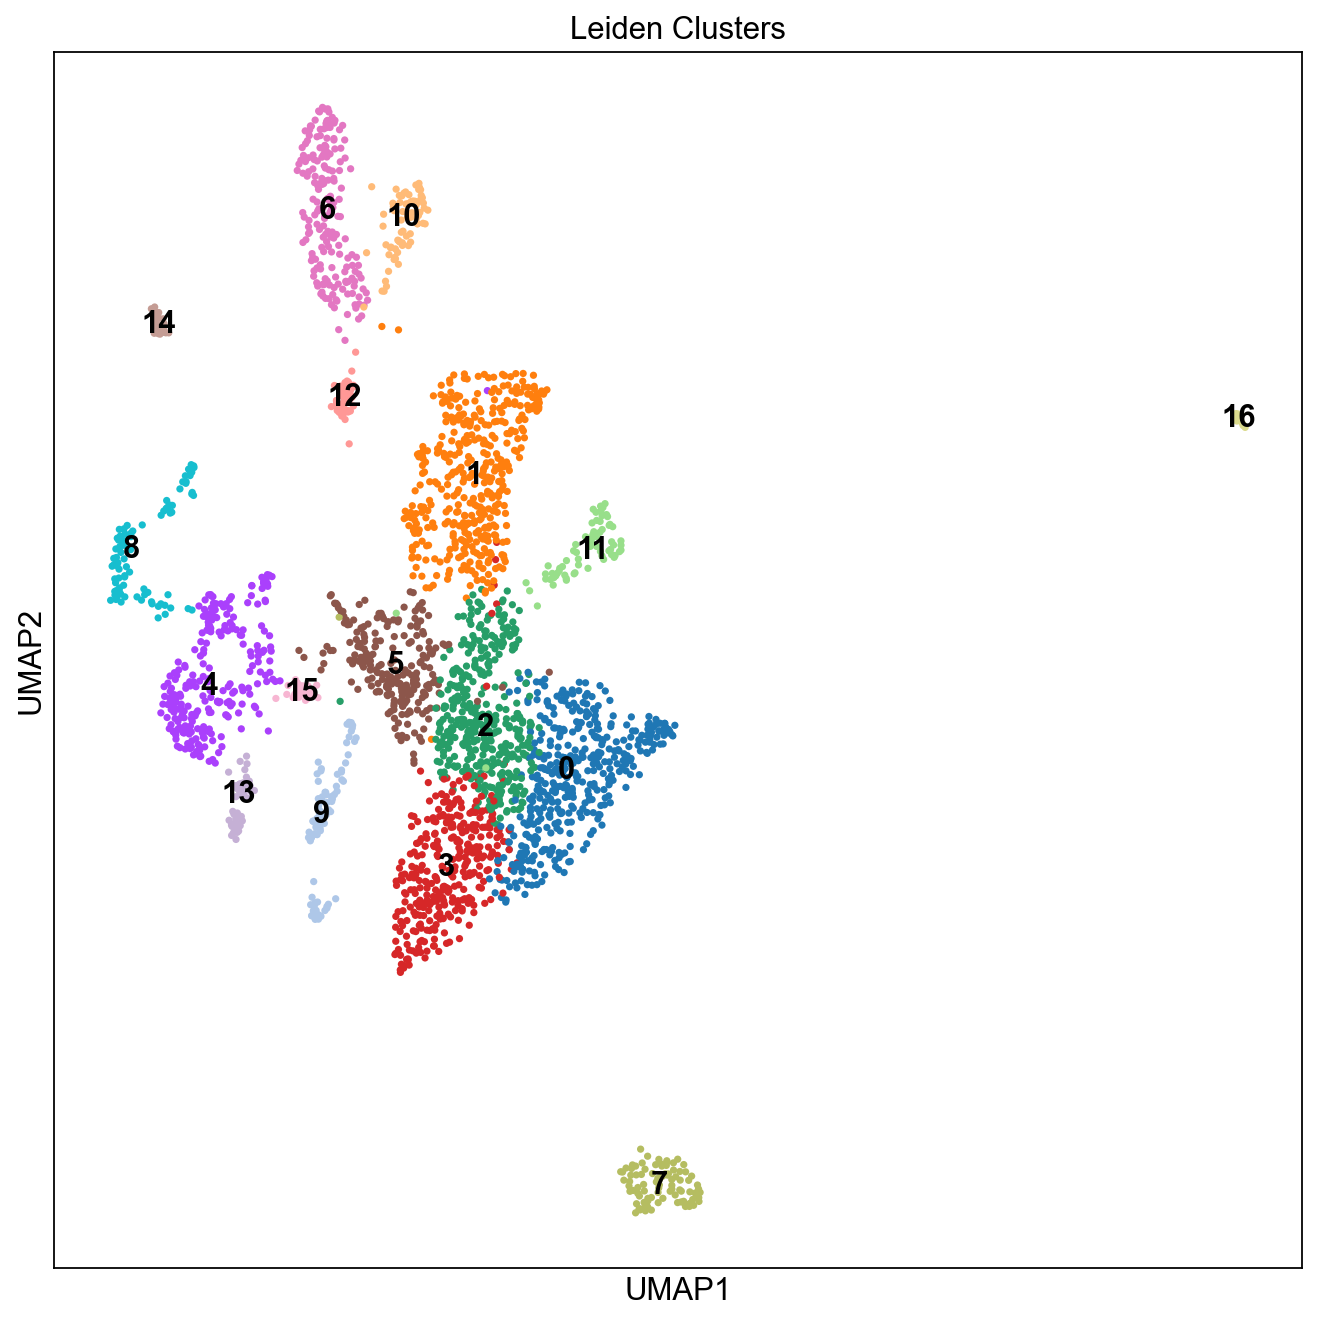

In [10]:
# Visualize clusters
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='Leiden Clusters', show=False)
# save image to output directory
plt.savefig(os.path.join(sc_output_dir, 'umap_leiden_clusters.png'), dpi=150, bbox_inches='tight')
print(f"UMAP plot saved to {os.path.join(sc_output_dir, 'umap_leiden_clusters.png')}")
plt.show()

## Batch Integration with Harmony

Harmony is used to integrate multiple datasets or batches while preserving biological variation. This step assesses how well cell type clustering is preserved across different datasets or experimental conditions.

In [11]:
# Check if batch information exists in the data
# For comparing different datasets (e.g., estrus vs diestrus), first merge them:

# OPTION 1: If you have separate datasets to combine
adata_estrus = sc.read_h5ad('../data/processed/estrus.23.01.26/preprocessed_data.h5ad')
adata_diestrus = sc.read_h5ad('../data/processed/22.01.26/preprocessed_data.h5ad')

# Add stage labels
adata_estrus.obs['stage'] = 'estrus'
adata_diestrus.obs['stage'] = 'diestrus'

# Concatenate datasets
adata = adata_estrus.concatenate(adata_diestrus, batch_key='stage', batch_categories=['estrus', 'diestrus'])
print("✓ Merged estrus and diestrus datasets")
print(f"  Combined shape: {adata.shape[0]} cells x {adata.shape[1]} genes")

# Clear any existing PCA/UMAP from individual datasets
if 'X_pca' in adata.obsm:
    del adata.obsm['X_pca']
    print("  Cleared old PCA from concatenated data")
if 'X_umap' in adata.obsm:
    del adata.obsm['X_umap']
    print("  Cleared old UMAP from concatenated data")

# Recompute highly variable genes on merged dataset
print("  Computing highly variable genes on merged dataset...")
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    flavor='seurat',
    batch_key='stage'  # Account for batch when finding HVGs
)
print(f"  Found {adata.var['highly_variable'].sum()} highly variable genes")

# Recompute PCA on merged dataset (required for Harmony)
print("  Computing PCA on merged dataset...")
sc.tl.pca(adata, n_comps=50, random_state=config['compute']['random_state'])
print(f"✓ PCA complete - shape: {adata.obsm['X_pca'].shape}")
print(f"  Expected shape: ({adata.n_obs}, 50)")

# Compute baseline clustering and UMAP on merged data (before Harmony)
print("\n  Computing baseline clustering on merged data...")
sc.pp.neighbors(adata, n_neighbors=config['cell_annotation']['n_neighbors'], 
                n_pcs=config['cell_annotation']['n_pcs'])
sc.tl.leiden(adata, resolution=1.0, random_state=config['compute']['random_state'])
sc.tl.umap(adata, min_dist=config['visualisation']['umap_min_dist'],
           spread=config['visualisation']['umap_spread'], 
           random_state=config['compute']['random_state'])
adata.obsm['X_umap_original'] = adata.obsm['X_umap'].copy()
print(f"✓ Baseline: {adata.obs['leiden'].nunique()} clusters computed")

# OPTION 2: If already merged, check for existing batch/stage column
batch_columns = ['batch', 'sample', 'donor', 'experiment', 'library', 'stage']
batch_key = None

for col in batch_columns:
    if col in adata.obs.columns:
        batch_key = col
        print(f"Found batch/stage information in column: '{batch_key}'")
        print(f"Categories: {adata.obs[batch_key].unique()}")
        print(f"Cells per category:\n{adata.obs[batch_key].value_counts()}")
        break

if batch_key is None:
    print("⚠️  No batch/stage information found in adata.obs")
    print("Available columns:", adata.obs.columns.tolist())
    print("\n📋 To compare estrus vs diestrus datasets:")
    print("1. Load both datasets separately")
    print("2. Add stage labels: adata.obs['stage'] = 'estrus' (or 'diestrus')")
    print("3. Merge: adata_combined = adata_estrus.concatenate(adata_diestrus, batch_key='stage')")
    print("4. Re-run preprocessing and clustering on the combined dataset")
    print("\nSkipping Harmony integration for now.")
else:
    print(f"\n✓ Ready for Harmony integration using batch key: '{batch_key}'")

C:\Users\dell\AppData\Local\Temp\ipykernel_12168\2494890761.py:13: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_estrus.concatenate(adata_diestrus, batch_key='stage', batch_categories=['estrus', 'diestrus'])


✓ Merged estrus and diestrus datasets
  Combined shape: 10779 cells x 21406 genes
  Cleared old PCA from concatenated data
  Computing highly variable genes on merged dataset...
extracting highly variable genes
    finished (0:00:10)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
  Found 2000 highly variable genes
  Computing PCA on merged dataset...
computing PCA
    with n_comps=50
    finished (0:00:09)
✓ PCA complete - shape: (10779, 50)
  Expected shape: (10779, 50)

  Computing baseline clustering on merged data...
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:31)
running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (

In [12]:
# Run Harmony integration (if batch information is available)
if batch_key is not None:
    import harmonypy as hm
    
    print("Running Harmony integration...")
    print(f"Using batch key: '{batch_key}'")
    print(f"Data shape: {adata.shape}")
    print(f"X_pca shape before Harmony: {adata.obsm['X_pca'].shape}")
    
    # Save original embedding for comparison
    adata.obsm['X_pca_original'] = adata.obsm['X_pca'].copy()
    
    # Run Harmony directly (scanpy wrapper has transpose issue)
    # harmonypy expects (n_cells, n_pcs) format
    pca_data = adata.obsm['X_pca'].astype(np.float64)
    print(f"Running Harmony on matrix shape: {pca_data.shape}")
    
    harmony_out = hm.run_harmony(
        pca_data,
        adata.obs,
        batch_key,
        max_iter_harmony=10,
        verbose=True
    )
    
    # Z_corr is already in correct shape (n_cells, n_pcs) - do NOT transpose!
    print(f"Harmony output shape: {harmony_out.Z_corr.shape}")
    adata.obsm['X_pca_harmony'] = harmony_out.Z_corr
    
    print("✓ Harmony integration complete")
    print(f"X_pca_harmony shape: {adata.obsm['X_pca_harmony'].shape}")
    print(f"Harmony-corrected PCs stored in: 'X_pca_harmony'")
    
    # Recompute neighbors using Harmony-corrected PCs
    sc.pp.neighbors(
        adata,
        n_neighbors=config['cell_annotation']['n_neighbors'],
        n_pcs=config['cell_annotation']['n_pcs'],
        use_rep='X_pca_harmony'
    )
    
    # Recompute UMAP on Harmony-corrected data
    sc.tl.umap(
        adata,
        min_dist=config['visualisation']['umap_min_dist'],
        spread=config['visualisation']['umap_spread'],
        random_state=config['compute']['random_state']
    )
    
    # Store Harmony UMAP
    adata.obsm['X_umap_harmony'] = adata.obsm['X_umap'].copy()
    
    # Recompute clustering on Harmony-corrected data
    sc.tl.leiden(
        adata,
        resolution=1.0,
        random_state=config['compute']['random_state'],
        key_added='leiden_harmony'
    )
    
    print(f"Harmony clusters: {adata.obs['leiden_harmony'].nunique()}")
    print("Original clusters:", adata.obs['leiden'].nunique())
else:
    print("Skipping Harmony integration - no batch information available")

2026-01-26 16:13:36,388 - harmonypy - INFO - Running Harmony (PyTorch on cpu)
2026-01-26 16:13:36,388 - harmonypy - INFO -   Parameters:
2026-01-26 16:13:36,388 - harmonypy - INFO -     max_iter_harmony: 10
2026-01-26 16:13:36,404 - harmonypy - INFO -     max_iter_kmeans: 20
2026-01-26 16:13:36,405 - harmonypy - INFO -     epsilon_cluster: 1e-05
2026-01-26 16:13:36,407 - harmonypy - INFO -     epsilon_harmony: 0.0001
2026-01-26 16:13:36,407 - harmonypy - INFO -     nclust: 100
2026-01-26 16:13:36,407 - harmonypy - INFO -     block_size: 0.05
2026-01-26 16:13:36,413 - harmonypy - INFO -     lamb: [1. 1.]
2026-01-26 16:13:36,413 - harmonypy - INFO -     theta: [2. 2.]
2026-01-26 16:13:36,413 - harmonypy - INFO -     sigma: [0.1 0.1 0.1 0.1 0.1]...
2026-01-26 16:13:36,416 - harmonypy - INFO -     verbose: True
2026-01-26 16:13:36,419 - harmonypy - INFO -     random_state: 0
2026-01-26 16:13:36,420 - harmonypy - INFO -   Data: 50 PCs × 10779 cells
2026-01-26 16:13:36,421 - harmonypy - INFO

Running Harmony integration...
Using batch key: 'stage'
Data shape: (10779, 21406)
X_pca shape before Harmony: (10779, 50)
Running Harmony on matrix shape: (10779, 50)


2026-01-26 16:13:37,153 - harmonypy - INFO - KMeans initialization complete.
2026-01-26 16:13:37,222 - harmonypy - INFO - Iteration 1 of 10
2026-01-26 16:13:38,171 - harmonypy - INFO - Iteration 2 of 10
2026-01-26 16:13:39,141 - harmonypy - INFO - Iteration 3 of 10
2026-01-26 16:13:39,956 - harmonypy - INFO - Iteration 4 of 10
2026-01-26 16:13:40,412 - harmonypy - INFO - Iteration 5 of 10
2026-01-26 16:13:40,829 - harmonypy - INFO - Iteration 6 of 10
2026-01-26 16:13:41,263 - harmonypy - INFO - Converged after 6 iterations


Harmony output shape: (10779, 50)
✓ Harmony integration complete
X_pca_harmony shape: (10779, 50)
Harmony-corrected PCs stored in: 'X_pca_harmony'
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:07)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden_harmony', the cluster labels (adata.obs, categorical) (0:00:02)
Harmony clusters: 13
Original clusters: 14


Comparison plot saved to z:\thornes\Pavlicev_lab_rotation\FLUXestimator\results\single_cell_annotations\combined.26.01.26\harmony_comparison_2.png


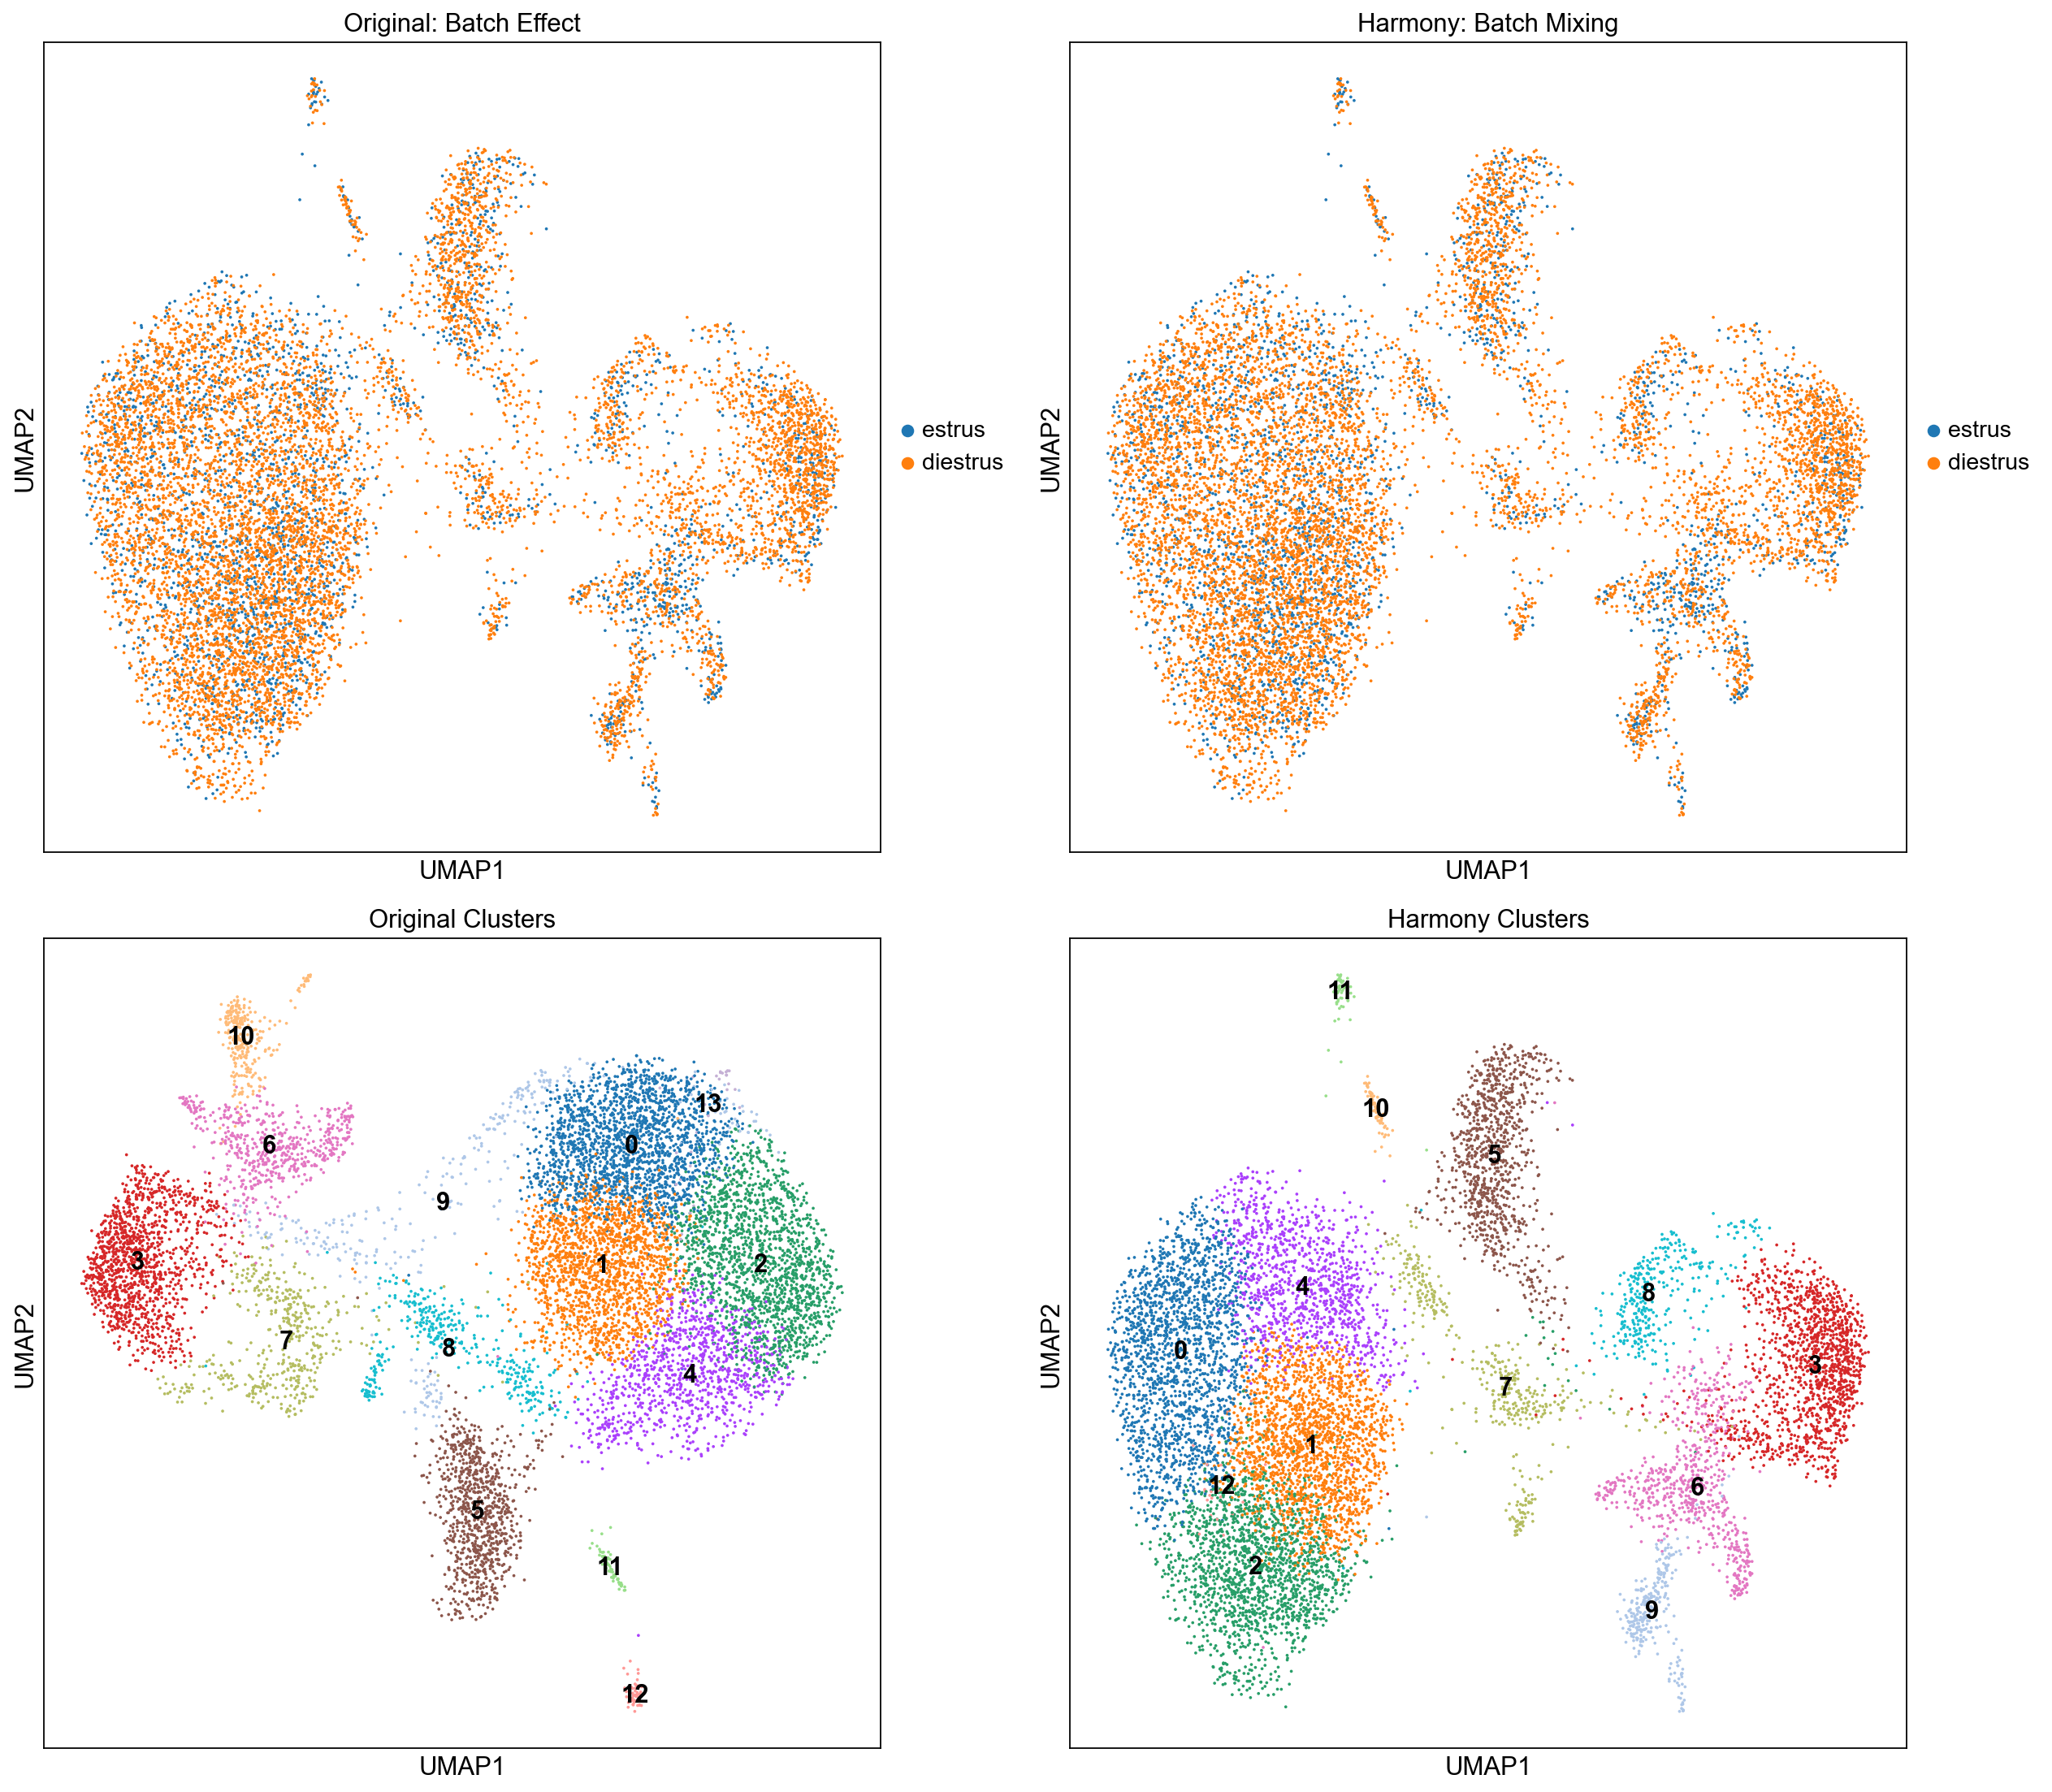

In [13]:
# Compare original vs Harmony-corrected clustering
if batch_key is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # Original UMAP colored by batch
    sc.pl.umap(adata, color=batch_key, ax=axes[0, 0], show=False, title='Original: Batch Effect')
    
    # Harmony UMAP colored by batch
    adata.obsm['X_umap'] = adata.obsm['X_umap_harmony']
    sc.pl.umap(adata, color=batch_key, ax=axes[0, 1], show=False, title='Harmony: Batch Mixing')
    
    # Original clustering
    adata.obsm['X_umap'] = adata.obsm.get('X_umap_original', adata.obsm['X_umap_harmony'])
    sc.pl.umap(adata, color='leiden', legend_loc='on data', ax=axes[1, 0], show=False, 
               title='Original Clusters')
    
    # Harmony clustering
    adata.obsm['X_umap'] = adata.obsm['X_umap_harmony']
    sc.pl.umap(adata, color='leiden_harmony', legend_loc='on data', ax=axes[1, 1], show=False,
               title='Harmony Clusters')
    
    plt.tight_layout()
    plt.savefig(os.path.join(sc_output_dir, 'harmony_comparison_2.png'), dpi=150, bbox_inches='tight')
    print(f"Comparison plot saved to {os.path.join(sc_output_dir, 'harmony_comparison_2.png')}")
    plt.show()
    
    # Restore Harmony UMAP as default
    adata.obsm['X_umap'] = adata.obsm['X_umap_harmony']
else:
    print("No batch comparison to visualize")

In [14]:
# Quantify cluster preservation across batches
if batch_key is not None:
    from sklearn.metrics import adjusted_rand_score
    
    print("=" * 70)
    print("CLUSTER PRESERVATION ASSESSMENT")
    print("=" * 70)
    
    # Compare original vs Harmony clustering
    ari = adjusted_rand_score(adata.obs['leiden'], adata.obs['leiden_harmony'])
    print(f"\nAdjusted Rand Index (ARI) between original and Harmony clusters: {ari:.3f}")
    print("  (1.0 = perfect agreement, 0.0 = random)")
    
    # Cluster composition by batch - Original
    print("\n--- Original Clustering ---")
    orig_composition = pd.crosstab(adata.obs['leiden'], adata.obs[batch_key], normalize='index')
    print("Cluster composition by batch (% of cells in each cluster from each batch):")
    print(orig_composition.round(3))
    
    # Cluster composition by batch - Harmony
    print("\n--- Harmony Clustering ---")
    harm_composition = pd.crosstab(adata.obs['leiden_harmony'], adata.obs[batch_key], normalize='index')
    print("Cluster composition by batch (% of cells in each cluster from each batch):")
    print(harm_composition.round(3))
    
    # Calculate batch mixing metric
    # A well-mixed cluster should have similar proportions from each batch
    orig_mixing = orig_composition.std(axis=1).mean()
    harm_mixing = harm_composition.std(axis=1).mean()
    
    print(f"\nBatch mixing score (lower = better mixing):")
    print(f"  Original: {orig_mixing:.3f}")
    print(f"  Harmony:  {harm_mixing:.3f}")
    
    if harm_mixing < orig_mixing:
        print("✓ Harmony improved batch mixing")
    else:
        print("⚠️  Harmony did not substantially improve batch mixing")
    
    print("\n" + "=" * 70)
else:
    print("No batch information available for cluster preservation assessment")

CLUSTER PRESERVATION ASSESSMENT

Adjusted Rand Index (ARI) between original and Harmony clusters: 0.688
  (1.0 = perfect agreement, 0.0 = random)

--- Original Clustering ---
Cluster composition by batch (% of cells in each cluster from each batch):
stage   estrus  diestrus
leiden                  
0        0.270     0.730
1        0.268     0.732
2        0.205     0.795
3        0.179     0.821
4        0.381     0.619
5        0.274     0.726
6        0.424     0.576
7        0.218     0.782
8        0.239     0.761
9        0.161     0.839
10       0.287     0.713
11       0.281     0.719
12       0.500     0.500
13       0.065     0.935

--- Harmony Clustering ---
Cluster composition by batch (% of cells in each cluster from each batch):
stage           estrus  diestrus
leiden_harmony                  
0                0.249     0.751
1                0.267     0.733
2                0.262     0.738
3                0.178     0.822
4                0.303     0.697
5               

In [15]:
# Decide which clustering to use for downstream analysis
if batch_key is not None:
    print("Choose clustering for downstream analysis:")
    print("  - 'leiden' = Original clustering (may have batch effects)")
    print("  - 'leiden_harmony' = Harmony-corrected clustering (batch-integrated)")
    print("\nRecommendation: Use 'leiden_harmony' if batch effects are strong")
    print("                Use 'leiden' if batch effects are minimal")
    
    # Option to switch clustering
    # Uncomment the line below to use Harmony clustering for downstream analysis
    # adata.obs['leiden'] = adata.obs['leiden_harmony']
    
    print("\n✓ Both clusterings available for comparison")
    print("  To use Harmony clustering, run: adata.obs['leiden'] = adata.obs['leiden_harmony']")
else:
    print("No Harmony integration performed - using original clustering")

Choose clustering for downstream analysis:
  - 'leiden' = Original clustering (may have batch effects)
  - 'leiden_harmony' = Harmony-corrected clustering (batch-integrated)

Recommendation: Use 'leiden_harmony' if batch effects are strong
                Use 'leiden' if batch effects are minimal

✓ Both clusterings available for comparison
  To use Harmony clustering, run: adata.obs['leiden'] = adata.obs['leiden_harmony']


In [16]:
# Save concatenated expression matrix to CSV
print("Saving concatenated expression matrix...")

# Get expression data as DataFrame
expr_df_combined = pd.DataFrame(
    adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X,
    index=adata.obs_names,  # Cell barcodes as rows
    columns=adata.var_names  # Gene names as columns
)

# Transpose: genes as rows, cells as columns
expr_df_combined_t = expr_df_combined.T

# Save to CSV
combined_output_dir = f'../data/processed/{suffix}'
os.makedirs(combined_output_dir, exist_ok=True)
expr_df_combined_t.to_csv(f'{combined_output_dir}/expression_matrix.csv')

print(f"✓ Saved concatenated expression matrix: {expr_df_combined_t.shape[0]} genes x {expr_df_combined_t.shape[1]} cells")
print(f"  Location: {combined_output_dir}/expression_matrix.csv")

# Also save metadata with stage/batch information
adata.obs.to_csv(f'{combined_output_dir}/cell_metadata.csv')
print(f"✓ Saved cell metadata with stage labels")
print(f"  Location: {combined_output_dir}/cell_metadata.csv")

Saving concatenated expression matrix...


KeyboardInterrupt: 

## Marker Gene Identification

Find differentially expressed genes for each cluster.

In [17]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)

# Find marker genes for each cluster
sc.tl.rank_genes_groups(
    adata,
    groupby='leiden',
    method='wilcoxon',
    key_added='rank_genes'
)

print("Marker gene analysis complete")

ranking genes
    finished: added to `.uns['rank_genes']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:32)
Marker gene analysis complete


In [18]:
adata.obs.head(30)

n_genes_by_counts  total_counts  total_counts_mt  \
AAACCCACAGCTGAAG-1-estrus                362         608.0             15.0   
AAACCCAGTGATGGCA-1-estrus               3901       15807.0            247.0   
AAACCCATCCATTCGC-1-estrus               6246       41993.0           1754.0   
AAACCCATCTCATTGT-1-estrus               5538       33702.0            521.0   
AAACGAAAGCGTACAG-1-estrus               6958       45442.0            978.0   
AAACGAAGTCCTACAA-1-estrus               3540       15925.0            172.0   
AAACGAAGTGAGACCA-1-estrus               5306       26520.0            864.0   
AAACGAAGTGGTAACG-1-estrus                440         823.0             26.0   
AAACGCTAGCGTATAA-1-estrus               4120       17401.0            624.0   
AAACGCTAGGTAGTCG-1-estrus               4347       18541.0              9.0   
AAACGCTAGTGGACTG-1-estrus               4432       23847.0            981.0   
AAACGCTTCAACGAGG-1-estrus               1227        2672.0            104.0   
AAAGAACAGACATCCT-1-estrus                524         730.0             12.0   
AAAGGATAGTCCCAGC-1-estrus               4150       18319.0            411.0   
AAAGGATTCTGAGAAA-1-estrus               7542       64891.0           1416.0   
AAAGGGCCAATGCAAA-1-estrus               4153       16889.0            498.0   
AAAGGGCCACGTACAT-1-estrus               3632       16066.0            393.0   
AAAGGGCCATAGAGGC-1-estrus               5589       29428.0            957.0   
AAAGGGCGTACAGAGC-1-estrus               3856       15303.0            447.0   
AAAGGTATCGGAAGGT-1-estrus               2802        9717.0            241.0   
AAAGTCCAGTACTGTC-1-estrus               5179       25093.0           1004.0   
AAAGTCCGTAACTTCG-1-estrus               5399       29862.0            614.0   
AAAGTGAAGTCATGGG-1-estrus               6431       39649.0           1896.0   
AAAGTGACAAGGCTTT-1-estrus                377         637.0             76.0   
AAAGTGATCTTAAGGC-1-estrus               5162       25543.0            518.0   
AAATGGACATCCCACT-1-estrus               5160       29005.0            524.0   
AAATGGATCAGGACGA-1-estrus               5496       31259.0            924.0   
AAATGGATCTCGGTCT-1-estrus               3482       11584.0            672.0   
AACAAAGCACTTGAAC-1-estrus               6684       52654.0            911.0   
AACAAAGTCGGCTGGT-1-estrus               5418       27363.0           1621.0   

                           pct_counts_mt  doublet_score  predicted_doublet  \
AAACCCACAGCTGAAG-1-estrus       2.467105       0.014964              False   
AAACCCAGTGATGGCA-1-estrus       1.562599       0.021905              False   
AAACCCATCCATTCGC-1-estrus       4.176887       0.012903              False   
AAACCCATCTCATTGT-1-estrus       1.545902       0.019011              False   
AAACGAAAGCGTACAG-1-estrus       2.152194       0.146245              False   
AAACGAAGTCCTACAA-1-estrus       1.080063       0.015707              False   
AAACGAAGTGAGACCA-1-estrus       3.257919       0.046105              False   
AAACGAAGTGGTAACG-1-estrus       3.159173       0.019932              False   
AAACGCTAGCGTATAA-1-estrus       3.586001       0.014250              False   
AAACGCTAGGTAGTCG-1-estrus       0.048541       0.043678              False   
AAACGCTAGTGGACTG-1-estrus       4.113725       0.019011              False   
AAACGCTTCAACGAGG-1-estrus       3.892216       0.012268              False   
AAAGAACAGACATCCT-1-estrus       1.643836       0.035499              False   
AAAGGATAGTCCCAGC-1-estrus       2.243572       0.035499              False   
AAAGGATTCTGAGAAA-1-estrus       2.182121       0.080240              False   
AAAGGGCCAATGCAAA-1-estrus       2.948665       0.065574              False   
AAAGGGCCACGTACAT-1-estrus       2.446160       0.029149              False   
AAAGGGCCATAGAGGC-1-estrus       3.252005       0.026479              False   
AAAGGGCGTACAGAGC-1-estrus       2.920996       0.074830              False   
AAAGGTATCGGAAGGT-

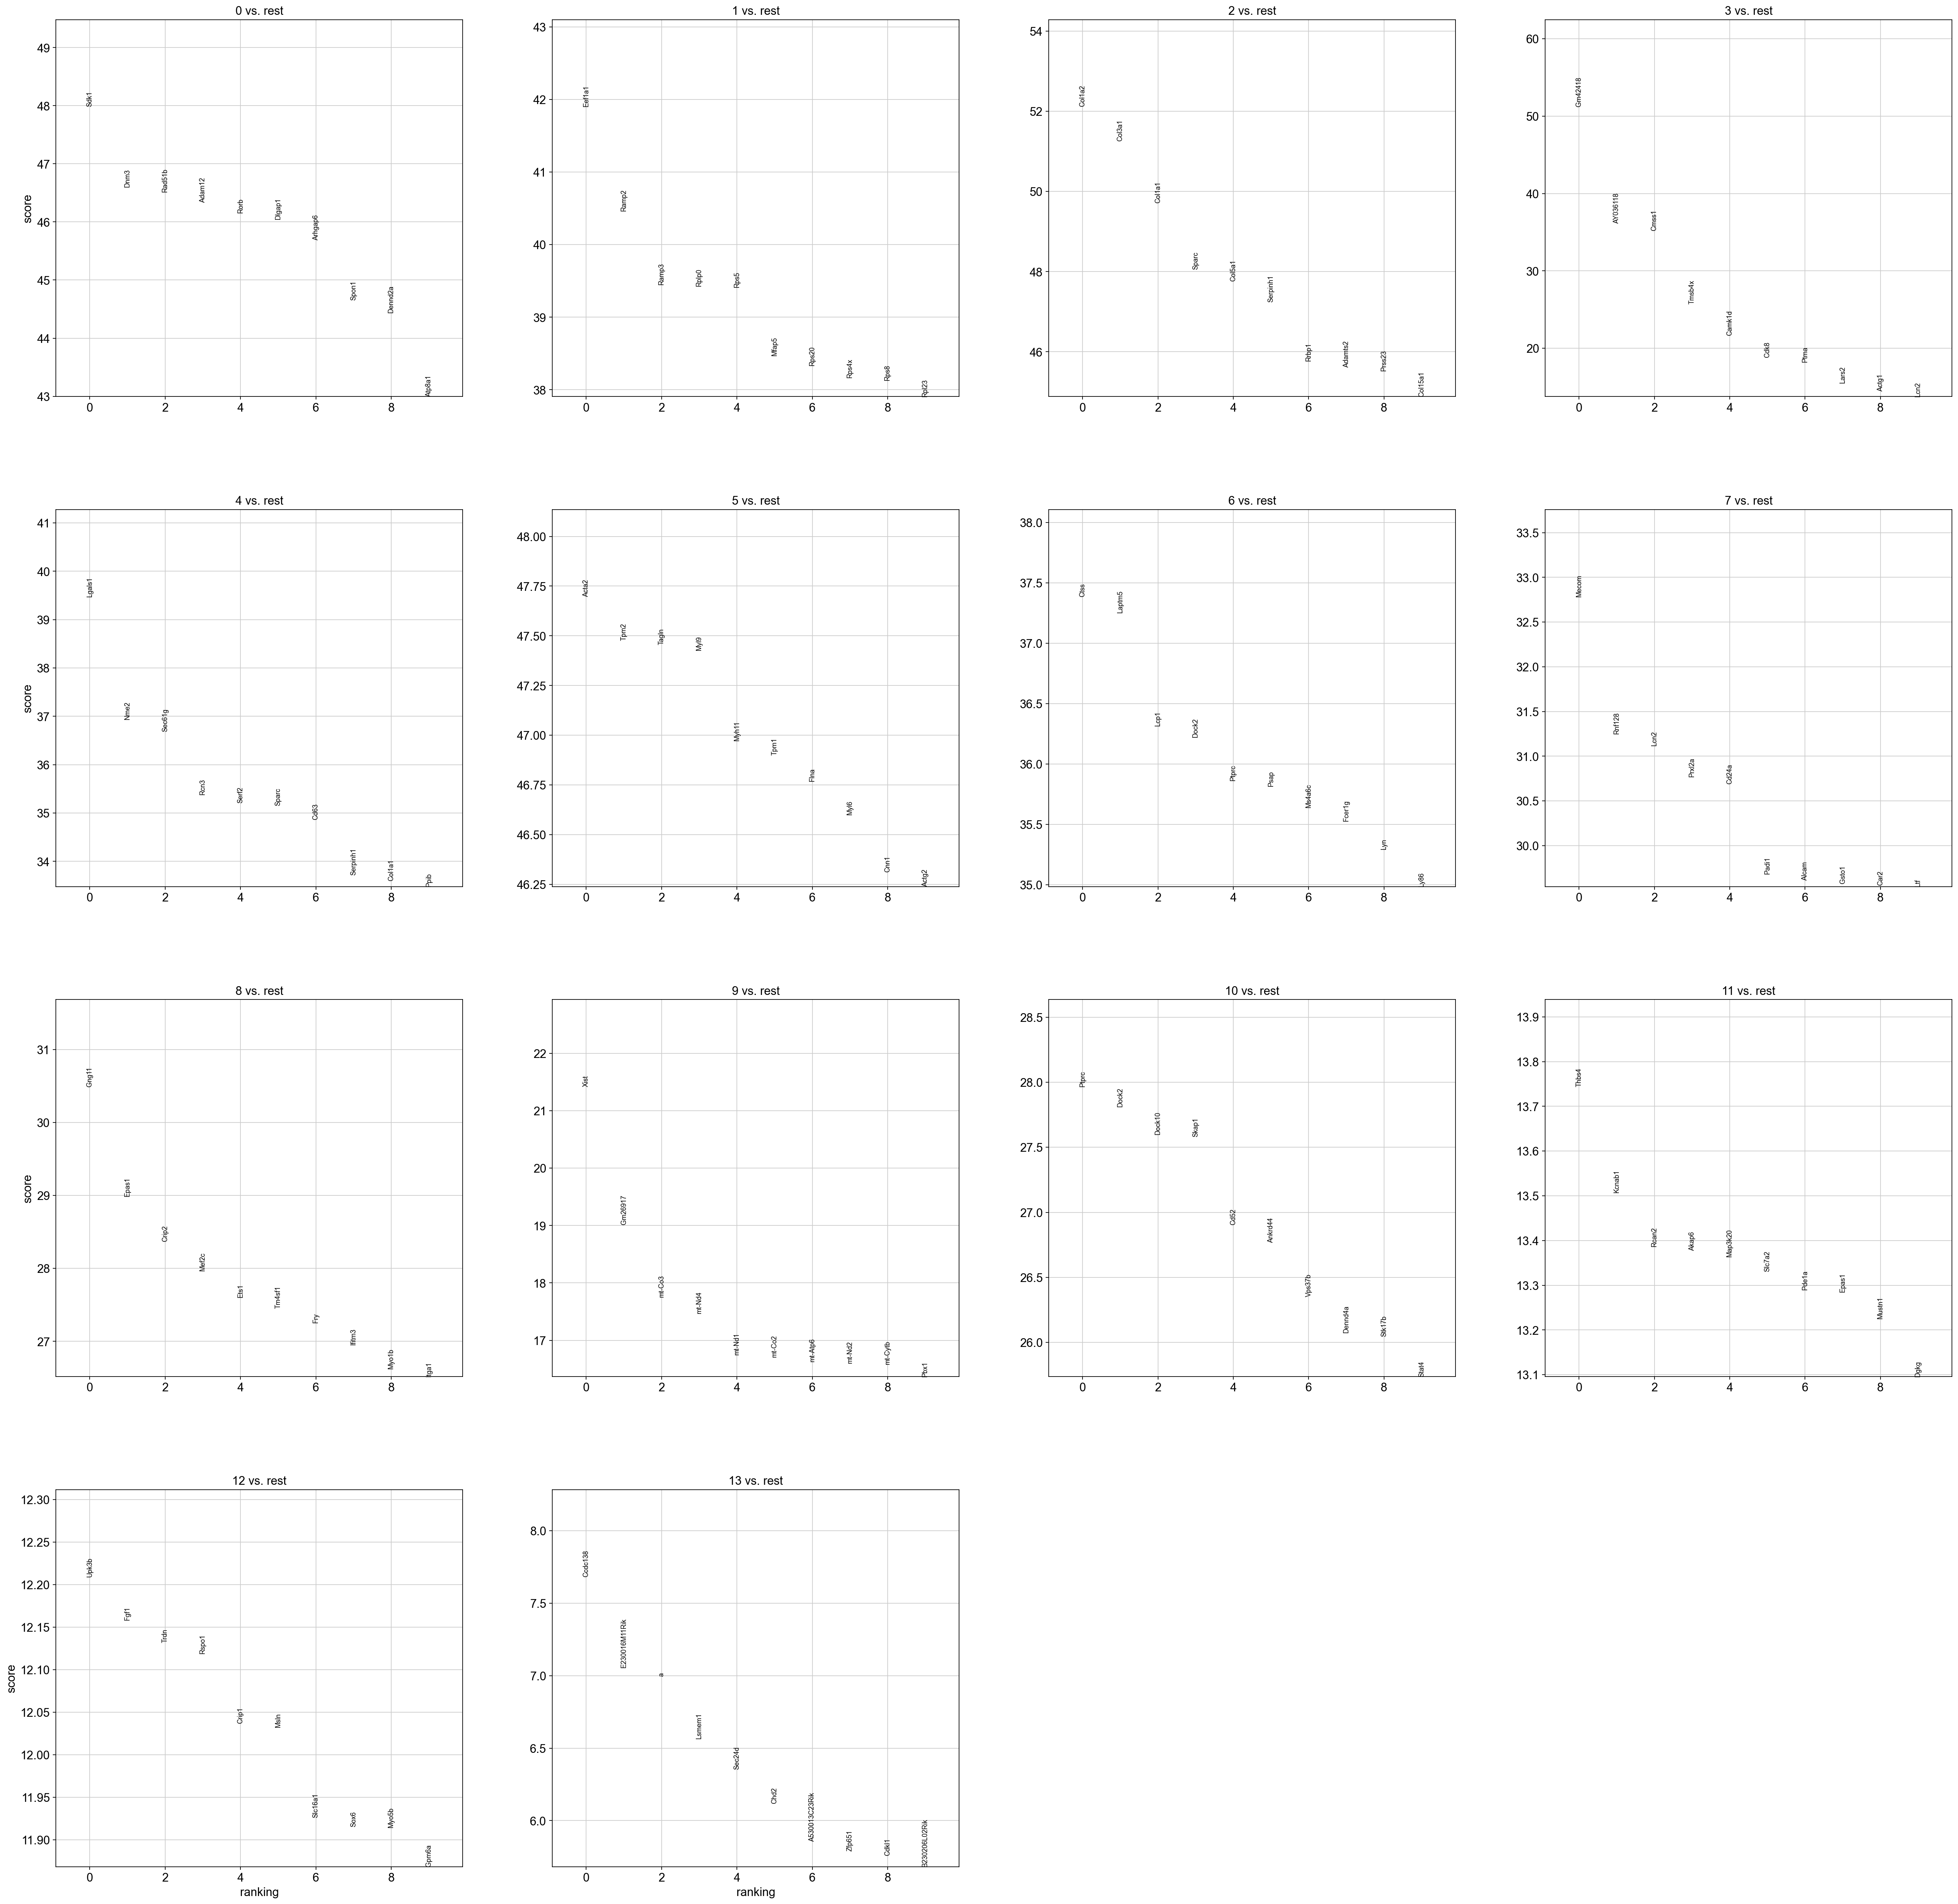

In [19]:
# Visualize top marker genes
sc.pl.rank_genes_groups(adata, n_genes=10, key='rank_genes', sharey=False)

In [20]:
# Get top marker genes as dataframe
marker_df = sc.get.rank_genes_groups_df(adata, group=None, key='rank_genes')
# save matrix
tab_output_dir = f'../results/tables/{suffix}'
os.makedirs(tab_output_dir, exist_ok=True)

marker_df.to_csv(f'{tab_output_dir}/marker_genes.csv', index=False)
marker_df.head(20)

group     names     scores  logfoldchanges  pvals  pvals_adj
0      0      Sdk1  47.985088             NaN    0.0        0.0
1      0      Dnm3  46.603249             NaN    0.0        0.0
2      0    Rad51b  46.520557             NaN    0.0        0.0
3      0    Adam12  46.332016             NaN    0.0        0.0
4      0      Rorb  46.160709             NaN    0.0        0.0
5      0    Dlgap1  46.048107             NaN    0.0        0.0
6      0   Arhgap6  45.686867             NaN    0.0        0.0
7      0     Spon1  44.652954             NaN    0.0        0.0
8      0   Dennd2a  44.436634             NaN    0.0        0.0
9      0    Atp8a1  42.995785             NaN    0.0        0.0
10     0      Sox5  42.337093             NaN    0.0        0.0
11     0   Lncpint  42.180229             NaN    0.0        0.0
12     0     Foxp2  42.058384             NaN    0.0        0.0
13     0     Lama2  41.857983             NaN    0.0        0.0
14     0      Ank3  41.851307             NaN    0.0        0.0
15     0    Col6a4  41.652893             NaN    0.0        0.0
16     0   Phactr1  41.122803             NaN    0.0        0.0
17     0     Robo1  40.831787             NaN    0.0        0.0
18     0  Adamts12  40.713181             NaN    0.0        0.0
19     0  Crispld2  40.479332             NaN    0.0        0.0

## Cell Type Annotation

Annotate clusters based on known marker genes.

Dotplot saved to z:\thornes\Pavlicev_lab_rotation\FLUXestimator\results\single_cell_annotations\combined.26.01.26\dotplot_marker_genes.png


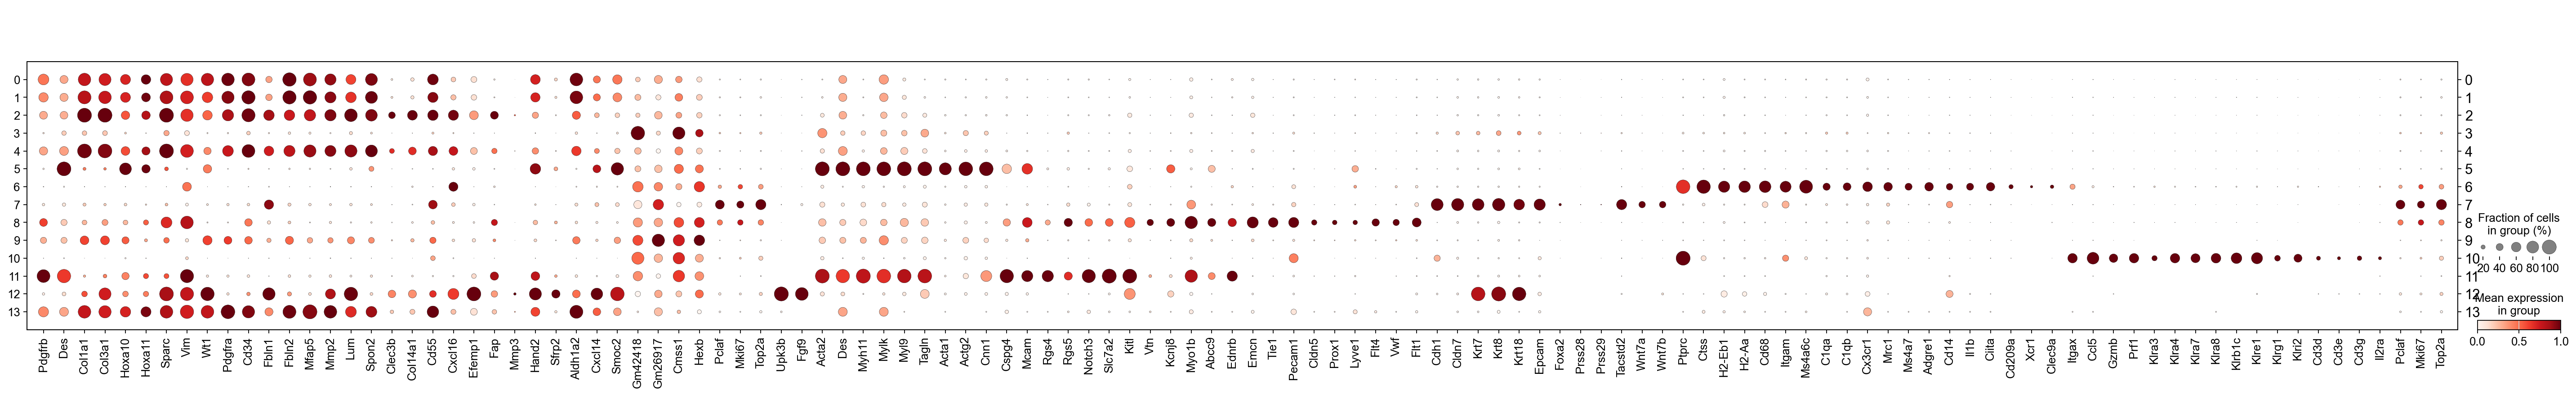

In [21]:
# Define marker genes for reproductive tissue cell types
marker_genes = config['cell_annotation']['marker_genes']

# Visualize marker gene expression
all_markers = [gene for genes in marker_genes.values() for gene in genes]
available_markers = [g for g in all_markers if g in adata.var_names]

if len(available_markers) > 0:
    sc.pl.dotplot(
        adata,
        var_names=available_markers[:150],  # Show first 150 available markers
        groupby='leiden',
        standard_scale='var',
        show=False
    )
    
    # Add cluster labels on the right side for easier cross-referencing
    fig = plt.gcf()
    axes = fig.get_axes()
    # The main dotplot axis is typically the largest one with ytick labels
    main_ax = None
    for ax in axes:
        if len(ax.get_yticklabels()) > 0:
            main_ax = ax
            break
    
    if main_ax is not None:
        ax2 = main_ax.twinx()
        ax2.set_ylim(main_ax.get_ylim())
        ax2.set_yticks(main_ax.get_yticks())
        ax2.set_yticklabels([label.get_text() for label in main_ax.get_yticklabels()])
        ax2.grid(False)  # Disable grid lines on the right axis
        ax2.set_ylabel('')  # No label needed
    
    # Adjust legend position to avoid overlap with right labels
    for ax in axes:
        legend = ax.get_legend()
        if legend is not None:
            # Move legend to the right, keeping it at the bottom
            legend.set_bbox_to_anchor((1.5, 0.0))
            legend.set_loc('lower left')
    
    # save image to output directory
    plt.savefig(os.path.join(sc_output_dir, 'dotplot_marker_genes.png'), dpi=150, bbox_inches='tight')
    print(f"Dotplot saved to {os.path.join(sc_output_dir, 'dotplot_marker_genes.png')}")
    plt.show()
else:
    print("Note: Marker genes not found in dataset.")

In [25]:
# Manual annotation based on marker gene expression

# Dioestrus stage
# cluster_annotations = {
#     '0': 'Fibroblast Cells',
#     '1': 'Fibroblast Cells',
#     '2': 'Inner Fibroblast Cells',
#     '3': 'Fibroblasts: Clec3b+ (outer/basal)',
#     '4': 'Myometrium',
#     '5': 'Fibroblast Cells',
#     '6': 'Epithelial Cells',
#     '7': 'Luminal Epithelial Cells',
#     '8': 'Macrophage Cells',
#     '9': 'Vascular Endothelial Cells',
#     '10': 'Ignore',
#     '11': 'Natural Killer Cells',
#     '12': 'Perivascular/Mural Cells',
#     '13': 'Lymphatic Endothelial Cells',
#     '14': 'Proliferating Fibroblast Cells',
#     '15': 'Glandular Epithelial Cells',
#     '16': 'Dendritic Monocyte Cells',
#     '17': 'Inconclusive',
#     '18': 'Mesothelial Cells',
#     '19': 'T Cells'
# }

# Oestrus stage
# cluster_annotations = {
#     '0': 'Inner Fibroblast Cells',
#     '1': 'Fibroblasts: Clec3b+ (outer/basal)',
#     '2': 'Fibroblast Cells',
#     '3': 'Fibroblast Cells',
#     '4': 'Dendritic Immune Cells',
#     '5': 'Fibroblast Cells',
#     '6': 'Myometrial Smooth Muscle Cells',
#     '7': 'Luminal Epithelial Cells',
#     '8': 'Natural Killer Cells',
#     '9': 'Perivascular Cells',
#     '10': 'Myometrial Cells',
#     '11': 'Vascular Endothelial Cells',
#     '12': 'Myometrial Cells',
#     '13': 'Macrophages/ Proliferating Monocyte Cells',
#     '14': 'Mesothelial Cells',
#     '15': 'Ignore',
#     '16': 'Lymphatic Endothelial Cells'
# }

# Combined dataset - original leiden clustering (pre-Harmony)
cluster_annotations = {
    '0': 'Fibroblast Cells',
    '1': 'Fibroblast Cells',
    '2': 'Fibroblasts: Clec3b+ (outer/basal)',
    '3': 'Ignore',
    '4': 'Fibroblast Cells',
    '5': 'Myometrial Smooth Muscle Cells',
    '6': 'Immune Monocyte Cells',
    '7': 'Luminal Epithelial Cells',
    '8': 'Endothelial Cells',
    '9': 'Ignore',
    '10': 'Natural Killer Cells',
    '11': 'Perivascular Cells',
    '12': 'Mesothelial Cells',
    '13': 'Fibroblast Cells'
}

# Map cluster IDs to cell type names using original leiden clustering
print(f"Using clustering: 'leiden' (original clusters from concatenated dataset)")
print(f"Available clusters: {sorted(adata.obs['leiden'].unique())}")
adata.obs['cell_type'] = adata.obs['leiden'].map(cluster_annotations)

# For unmapped clusters, keep cluster ID
adata.obs['cell_type'] = adata.obs['cell_type'].fillna('Cluster ' + adata.obs['leiden'].astype(str))

print("\nCell type annotations:")
print(adata.obs['cell_type'].value_counts())
# save annotated data
adata.obs.to_csv(os.path.join(sc_output_dir, 'annotated_data.csv'))
print(f"Annotated data saved to {os.path.join(sc_output_dir, 'annotated_data.csv')}")

Using clustering: 'leiden' (original clusters from concatenated dataset)
Available clusters: ['0', '1', '10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']

Cell type annotations:
cell_type
Fibroblast Cells                      4729
Fibroblasts: Clec3b+ (outer/basal)    1715
Ignore                                1629
Myometrial Smooth Muscle Cells         886
Immune Monocyte Cells                  568
Luminal Epithelial Cells               454
Endothelial Cells                      402
Natural Killer Cells                   282
Perivascular Cells                      64
Mesothelial Cells                       50
Name: count, dtype: int64
Annotated data saved to z:\thornes\Pavlicev_lab_rotation\FLUXestimator\results\single_cell_annotations\combined.26.01.26\annotated_data.csv


Using original UMAP coordinates (pre-Harmony) for visualization
Plotting 9150 cells (excluded 1629 unassigned cells)
UMAP plot saved to z:\thornes\Pavlicev_lab_rotation\FLUXestimator\results\single_cell_annotations\combined.26.01.26\original_umap_cell_type_annotations.png


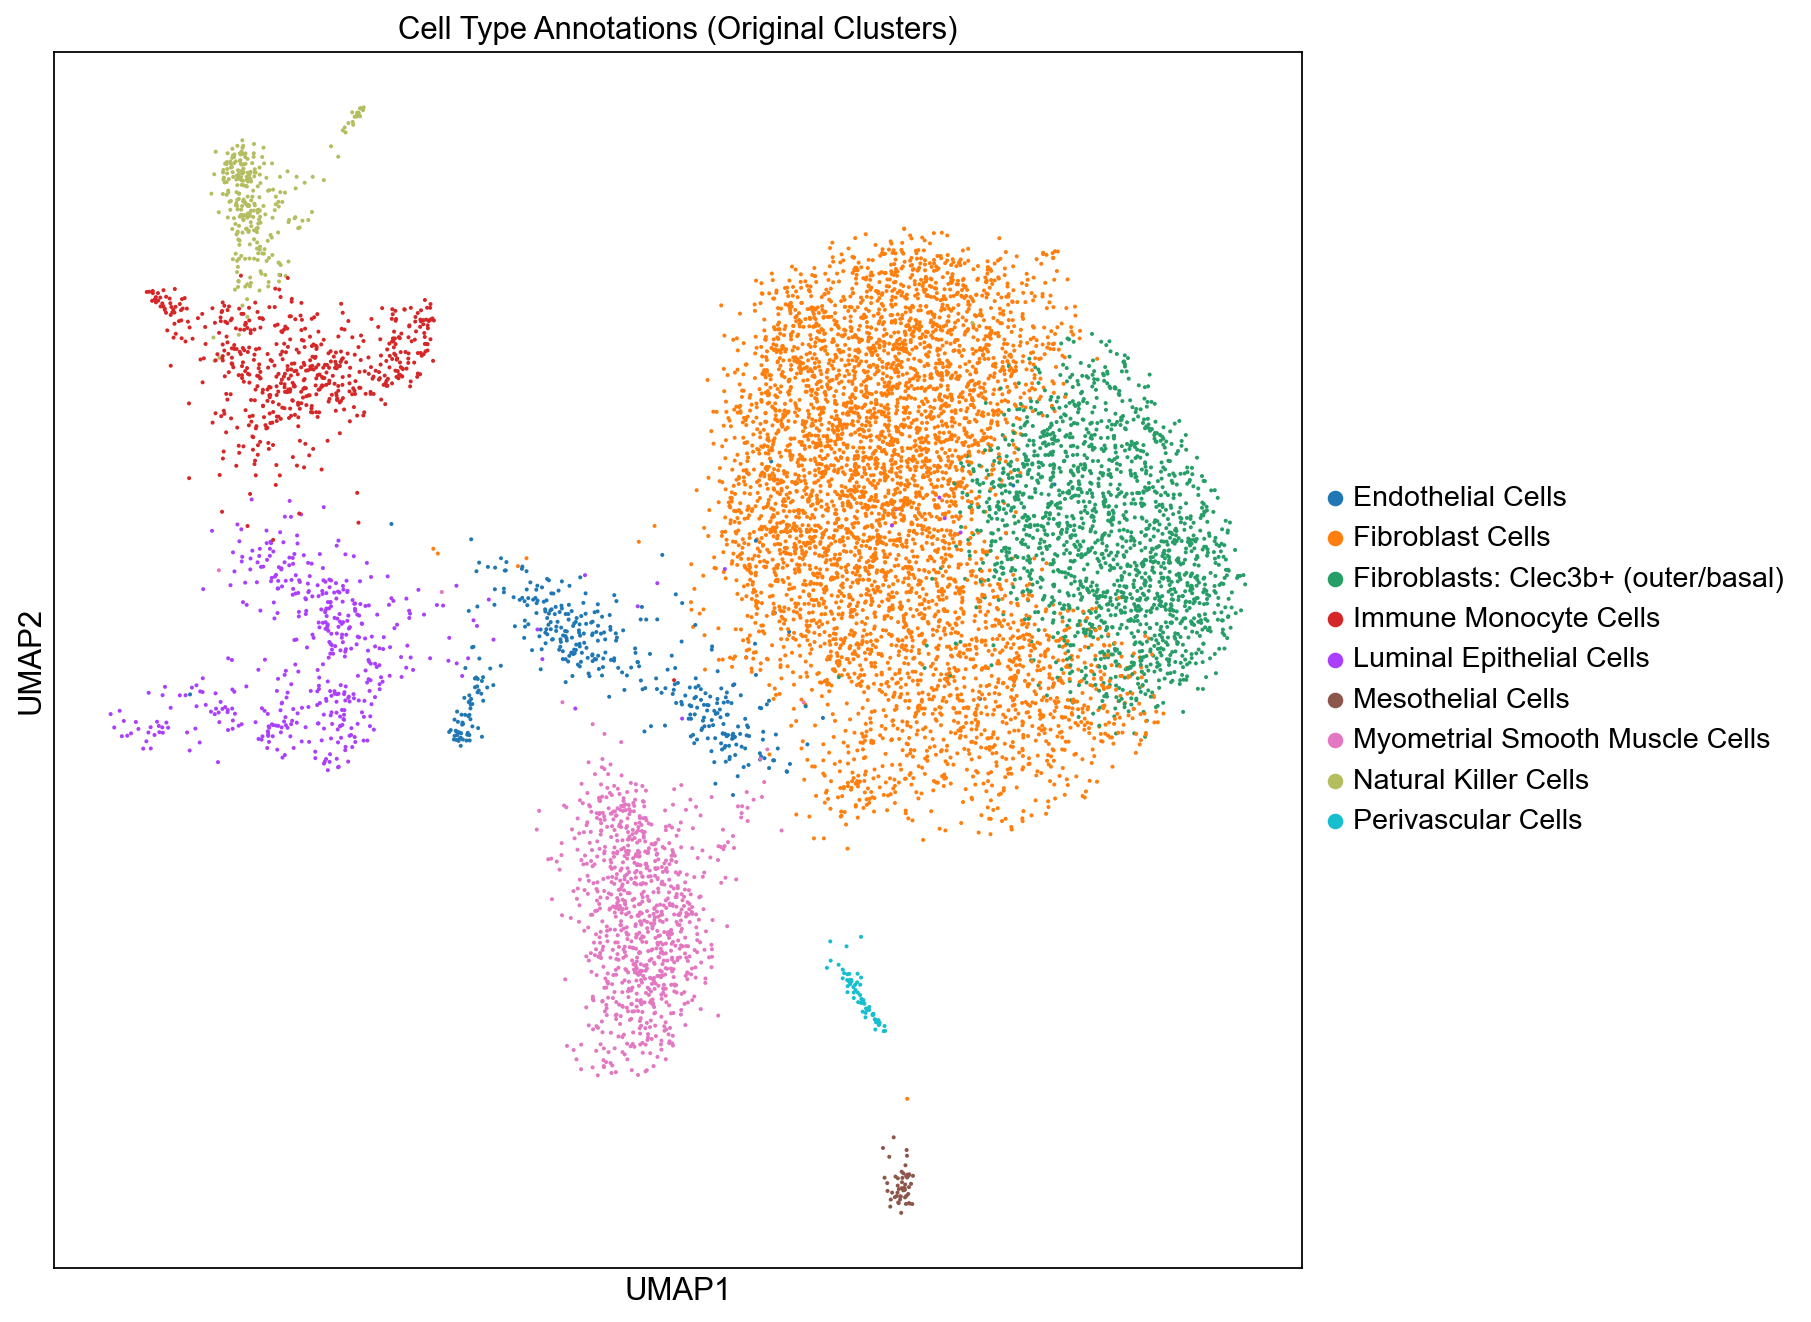

In [27]:
# Visualise cell types

# Switch back to original UMAP (pre-Harmony) for visualization
adata.obsm['X_umap'] = adata.obsm['X_umap_original']
print("Using original UMAP coordinates (pre-Harmony) for visualization")

# Filter out cells marked as 'Ignore' or 'Inconclusive'
adata_filtered = adata[~adata.obs['cell_type'].isin(['Ignore', 'Inconclusive'])].copy()

print(f"Plotting {adata_filtered.n_obs} cells (excluded {adata.n_obs - adata_filtered.n_obs} unassigned cells)")

sc.pl.umap(adata_filtered, color='cell_type', title='Cell Type Annotations (Original Clusters)', show = False)

# save image to output directory
plt.savefig(os.path.join(sc_output_dir, 'original_umap_cell_type_annotations.png'), dpi=150, bbox_inches='tight')
print(f"UMAP plot saved to {os.path.join(sc_output_dir, 'original_umap_cell_type_annotations.png')}")
plt.show()

## Quality Checks

Verify cell type annotations with QC metrics.

QC metrics plot saved to z:\thornes\Pavlicev_lab_rotation\FLUXestimator\results\single_cell_annotations\combined.26.01.26\qc_metrics_by_cell_type.png


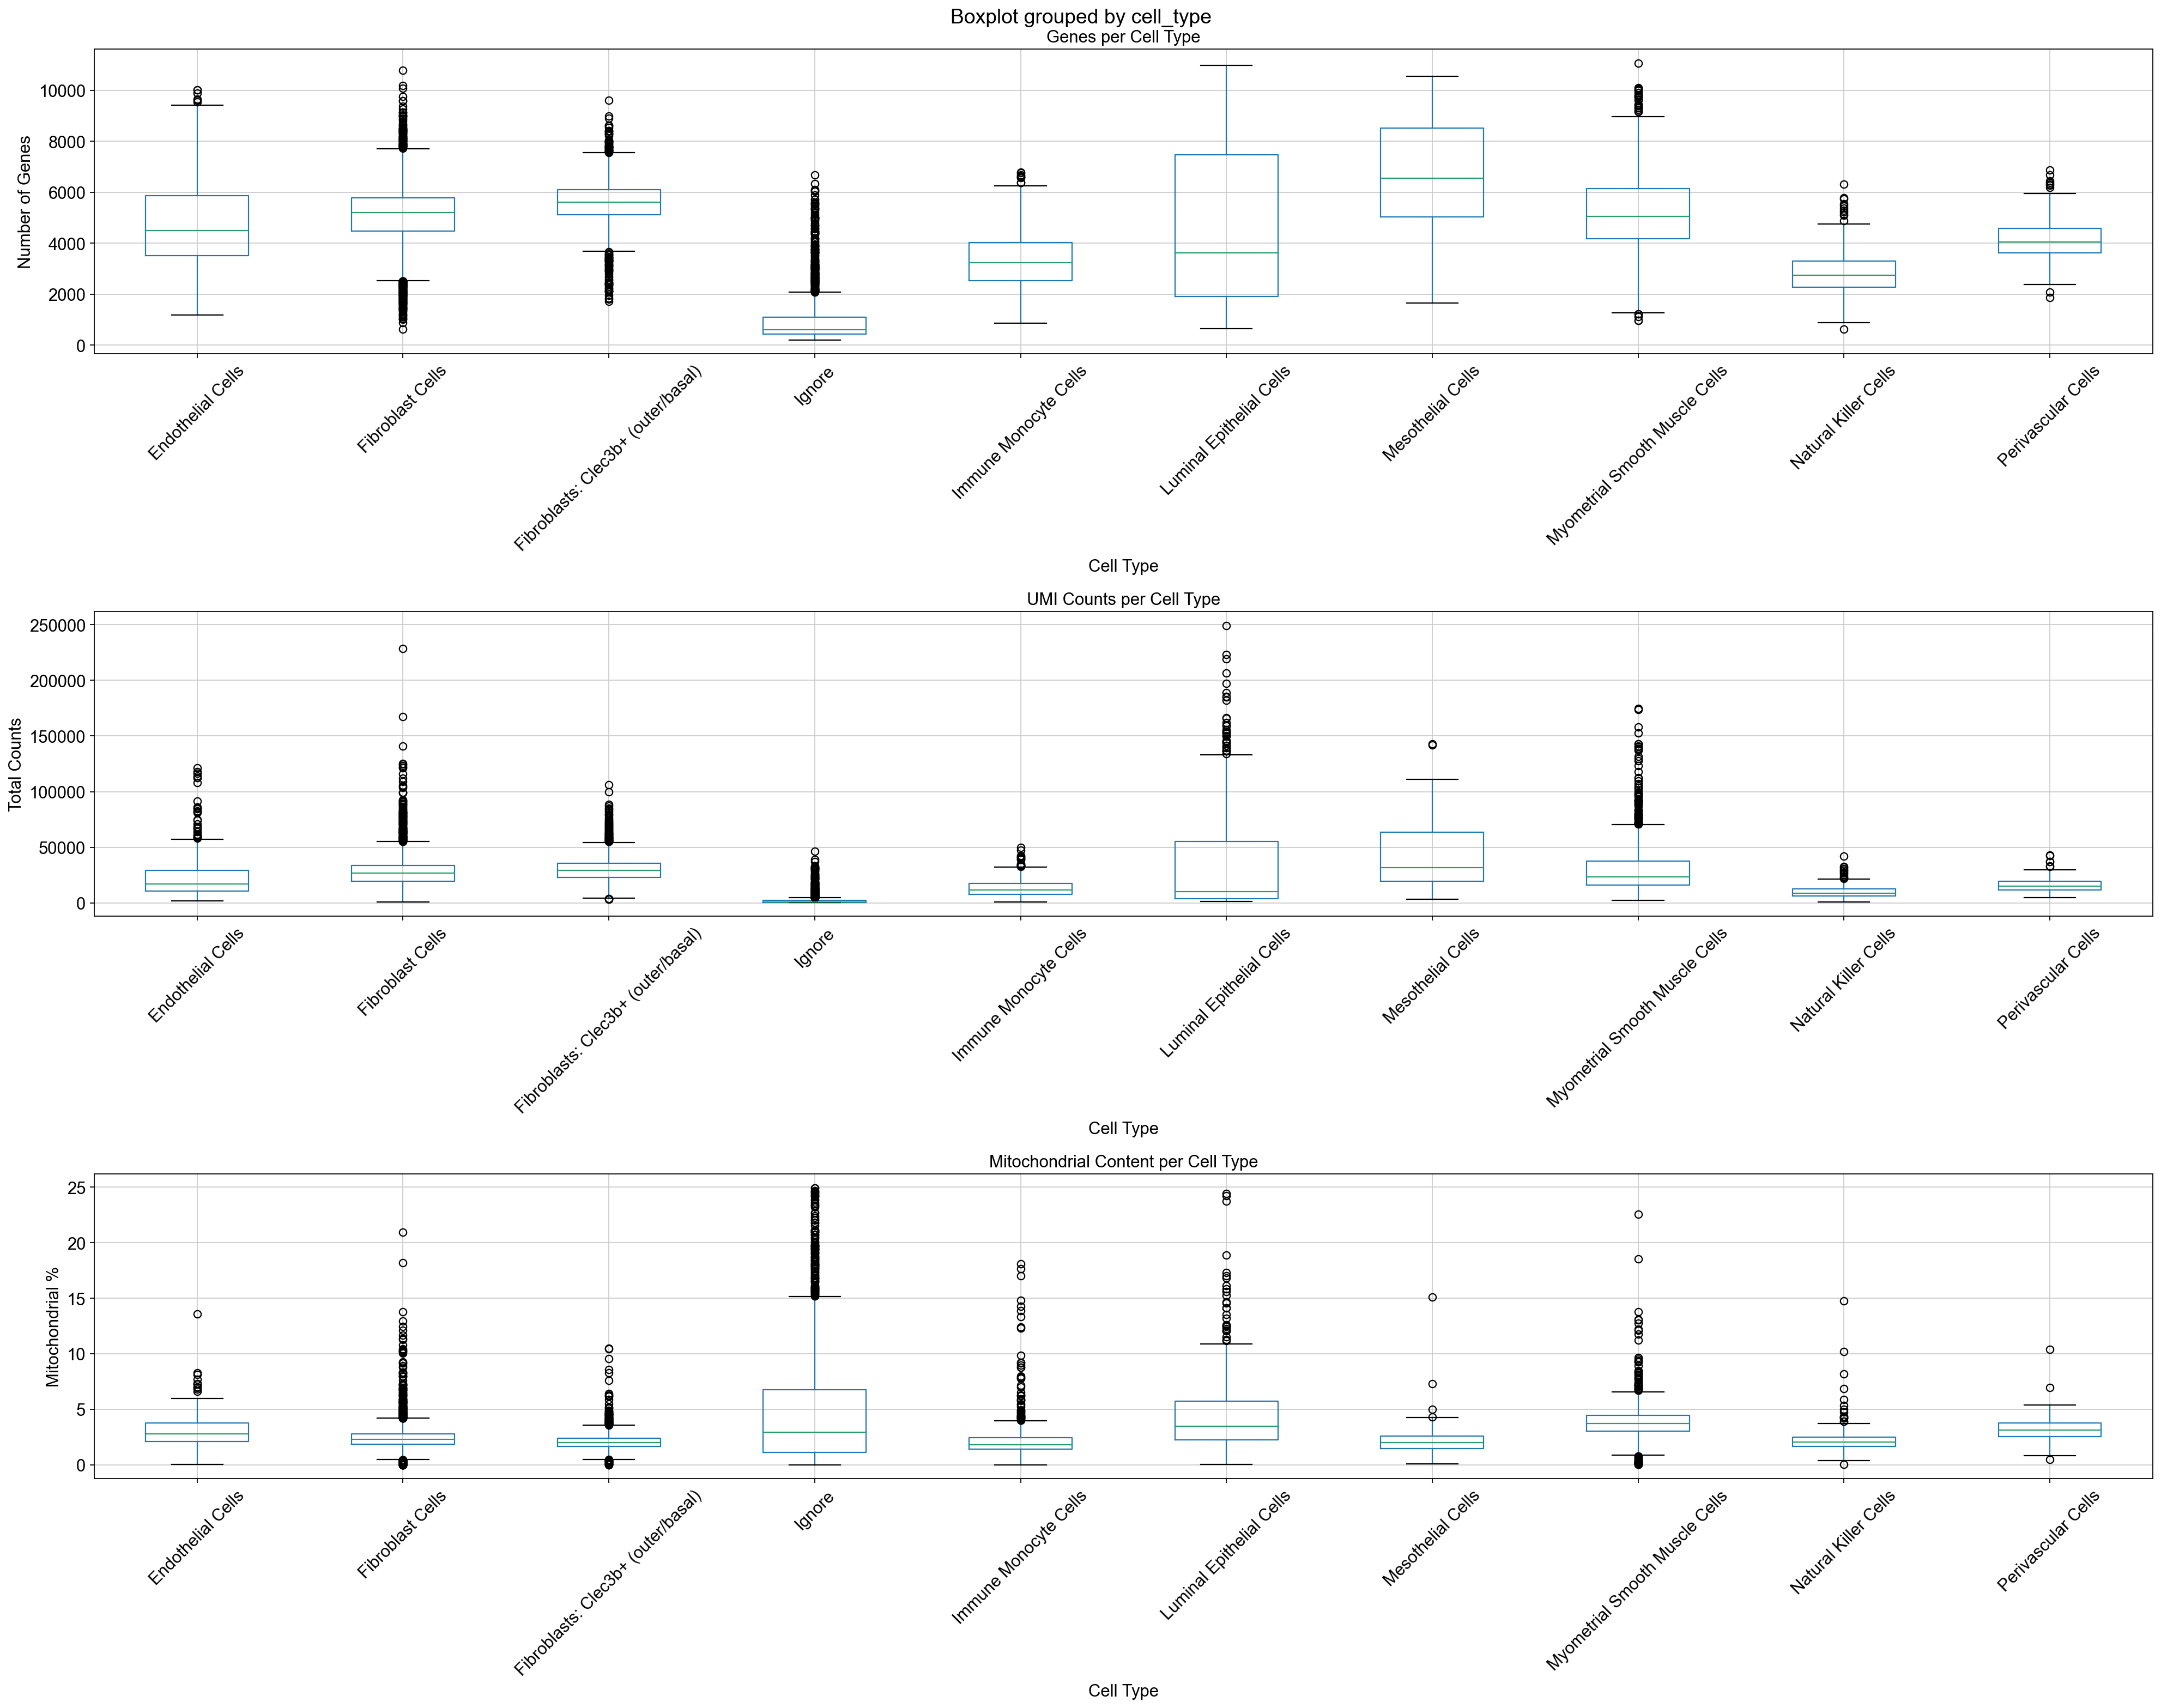

In [28]:
# Compare QC metrics across cell types
fig, axes = plt.subplots(3, 1, figsize=(25, 20))

# Number of genes
adata.obs.boxplot('n_genes_by_counts', by='cell_type', ax=axes[0])
axes[0].set_xlabel('Cell Type')
axes[0].set_ylabel('Number of Genes')
axes[0].set_title('Genes per Cell Type')
axes[0].tick_params(axis='x', rotation=45)

# Total counts
adata.obs.boxplot('total_counts', by='cell_type', ax=axes[1])
axes[1].set_xlabel('Cell Type')
axes[1].set_ylabel('Total Counts')
axes[1].set_title('UMI Counts per Cell Type')
axes[1].tick_params(axis='x', rotation=45)

# Mitochondrial percentage
adata.obs.boxplot('pct_counts_mt', by='cell_type', ax=axes[2])
axes[2].set_xlabel('Cell Type')
axes[2].set_ylabel('Mitochondrial %')
axes[2].set_title('Mitochondrial Content per Cell Type')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
# save image to output directory
plt.savefig(os.path.join(sc_output_dir, 'qc_metrics_by_cell_type.png'), dpi=150, bbox_inches='tight')
print(f"QC metrics plot saved to {os.path.join(sc_output_dir, 'qc_metrics_by_cell_type.png')}")
plt.show()

## Save Annotated Data

In [ ]:
# Save annotated data
output_file = f'../data/processed/{suffix}/annotated_data.h5ad'
mkdir_path = os.path.dirname(output_file)
if not os.path.exists(mkdir_path):
    os.makedirs(mkdir_path)
adata.write(output_file, compression='gzip')

print(f"Saved annotated data to {output_file}")
print(f"Dataset: {adata.shape[0]} cells x {adata.shape[1]} genes")
print(f"Cell types: {adata.obs['cell_type'].nunique()}")

Saved annotated data to ../data/processed/combined.26.01.26/annotated_data.h5ad
Dataset: 10779 cells x 21406 genes
Cell types: 10


In [29]:
# Filter genes by those used in scFEA analysis
scfea_genes = pd.read_csv('../data/reference/scFEA_metabolic_genes.csv', header=0).iloc[:, 0].tolist()
print(f"Total scFEA genes in reference: {len(scfea_genes)}")
print(f"First 20 scFEA genes: {scfea_genes[:20]}")

# expr_df_combined_t has genes as ROWS (index), cells as COLUMNS (concatenated dataset)
print(f"\nExpression matrix structure:")
print(f"  Shape: {expr_df_combined_t.shape}")
print(f"  Index (genes): {len(expr_df_combined_t.index)}")
print(f"  Columns (cells): {len(expr_df_combined_t.columns)}")

genes_in_data = [g for g in scfea_genes if g in expr_df_combined_t.index]
print(f"\nMatching genes found in expression matrix: {len(genes_in_data)}")

# Filter expression matrix to only include scFEA genes (select rows)
expr_df_filtered = expr_df_combined_t.loc[genes_in_data, :].copy()
print(f"\nFiltered expression matrix shape: {expr_df_filtered.shape}")

# Save filtered expression matrix
expr_df_filtered.to_csv(f'../data/processed/{suffix}/expr_mtx_scFEA_genes.csv')
print(f"Filtered expression matrix saved to '../data/processed/{suffix}/expr_mtx_scFEA_genes.csv'")

Total scFEA genes in reference: 719
First 20 scFEA genes: ['2410015N17Rik', '2410018C20Rik', '4631427C17Rik', '4732435N03Rik', '4833446K15Rik', 'A030007L17Rik', 'A530050D06Rik', 'Aacs', 'Aadat', 'Aass', 'Abat', 'Abo', 'Acaa1a', 'Acaa1b', 'Acaa2', 'Acaca', 'Acacb', 'Acad8', 'Acadl', 'Acadm']

Expression matrix structure:
  Shape: (21406, 10779)
  Index (genes): 21406
  Columns (cells): 10779

Matching genes found in expression matrix: 578

Filtered expression matrix shape: (578, 10779)
Filtered expression matrix saved to '../data/processed/combined.26.01.26/expr_mtx_scFEA_genes.csv'


## Next Steps

Proceed to notebook `03_flux_estimation.ipynb` for metabolic flux analysis.